In [1]:

import sys
import yaml
import phate
import torch
import pytorch_lightning as pl
from pytorch_lightning import Trainer
from pytorch_lightning.loggers import WandbLogger
import matplotlib.pyplot as plt
from sklearn.manifold import MDS
import scipy
import numpy as np
from math import pi
import matplotlib.pyplot as plt
from typing import Optional, List
from torchdyn.core import NeuralODE
import os
import scipy.io as sio


sys.path.append("../")
from src.models.lit_encoder import LitAutoencoder
from src.models.lit_encoder import LitDistEncoder
from src.data.make_dataset import train_dataloader
from src.data.make_dataset import make_n_sphere_two
from src.data.make_dataset import make_tree
from src.data.make_dataset import make_live_seq
from src.data.make_dataset import make_pbmc
from src.data.make_dataset import make_ipsc
from src.fim_noemb import FIM
from src.fim_noemb import FIM_torch
from src.fim_noemb import FIM_cpu

import os
from sklearn.decomposition import PCA
import math
import random
import pickle

import h5py
import numpy as np
import scipy.io as sio
import pandas as pd
import sklearn
import random
from src.models.lit_node import NODE, ToyODE
from src.data.make_dataset import make_swiss
from sklearn import datasets
from sklearn.manifold import Isomap 




In [2]:
from dataset import Dataset
from dataset import SwissRoll

In [123]:
#Define swiss roll
npts = 1500
ds = SwissRoll(n_points = npts, manifold_noise=0, width=1, rotate=True, rotate_dim=10)

In [124]:
#Get dataset
swiss_roll = ds.X


In [125]:
#Get geodesics
swiss_dist= ds.get_geodesic()

In [126]:
#Apply PCA for visualization

pca = PCA(n_components=3)
viswiss = pca.fit_transform(swiss_roll)

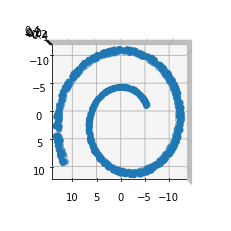

In [127]:
#Visualization 


fig = plt.figure()
ax = plt.axes(projection='3d')
ax.scatter(viswiss[:,0],viswiss[:,1],viswiss[:,2])
ax.view_init(90,90)


In [128]:
# Swiss roll random integer
start = np.random.randint(0,npts,size=1)
starttwo = np.random.randint(0,npts,size=1)
startthree = np.random.randint(0,npts,size=1)
startfour = np.random.randint(0,npts,size=1)
startfive= np.random.randint(0,npts,size=1)
end = np.random.randint(0,npts,size=1)





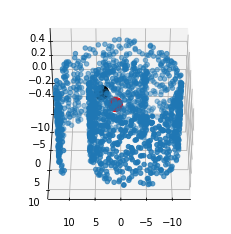

In [129]:
fig = plt.figure()
ax = plt.axes(projection='3d')
ax.scatter(viswiss[:,0],viswiss[:,1],viswiss[:,2])
ax.scatter(viswiss[start,0],viswiss[start,1],viswiss[start,2],c='black',s=200)
ax.scatter(viswiss[end,0],viswiss[end,1],viswiss[end,2],c='red',s=200)
ax.view_init(40,90)


In [130]:
#Isomap geodesic
embedding = Isomap(n_components=2)
iso_swiss = embedding.fit(swiss_roll)
isomap_dist = iso_swiss.dist_matrix_


print(isomap_dist.shape)


/gpfs/ysm/project/krishnaswamy_smita/of56/conda_envs/fashenv/lib/python3.10/site-packages/sklearn/manifold/_isomap.py:328: UserWarning: The number of connected components of the neighbors graph is 2 > 1. Completing the graph to fit Isomap might be slow. Increase the number of neighbors to avoid this issue.
  self._fit_transform(X)
/gpfs/ysm/project/krishnaswamy_smita/of56/conda_envs/fashenv/lib/python3.10/site-packages/scipy/sparse/_index.py:103: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
  self._set_intXint(row, col, x.flat[0])


(1500, 1500)


In [131]:
#Ground Truth and Isomap geodesics

gt_geo = swiss_dist[start,end]
gt_geotwo = swiss_dist[starttwo,end]
gt_geothree = swiss_dist[startthree,end]
gt_geofour = swiss_dist[startfour,end]
gt_geofive = swiss_dist[startfive,end]
iso_geo = isomap_dist[start,end]
iso_geotwo = isomap_dist[starttwo,end]
iso_geothree = isomap_dist[startthree,end]
iso_geofour = isomap_dist[startfour,end]
iso_geofive = isomap_dist[startfive,end]

gt_geo = np.array([gt_geo,gt_geotwo,gt_geothree,gt_geofour,gt_geofive])
iso_geo = np.array([iso_geo,iso_geotwo,iso_geothree,iso_geofour,iso_geofive])
print(gt_geo)
print(iso_geo)



[[0.57815511]
 [3.33182227]
 [7.89812017]
 [1.7379675 ]
 [2.73644246]]
[[ 3.67263449]
 [28.99316029]
 [87.98058104]
 [13.04236305]
 [23.26076437]]


In [132]:
#Save swiss roll dataset

np.save("saved_data/swiss_roll_exp.npy",swiss_roll)

In [133]:
#NeuralFIM


dataset = "swiss_roll_exp"
n_obs = 1500
n_dim = 10
batch_size = 300

# Model param
encoder_layer = [50,50,50]
decoder_layer = [2,10,10]
emb_dim = encoder_layer[-1]
activation = "ReLU"
lr = 0.0001
kernel_type = "phate"  # "gaussian" and "phate".
loss_emb = False  # Embedding loss.
loss_dist = True # distance loss in the embedding.
loss_rec = False
bandwitdh = 1  # bandwitdh for the gaussian kernel
t = 1  # time for the gaussian kernel. For PHATE, we use their optimal time.
scale = 0.0005  # scale when we add noise to do the data (before the encoder).
knn = 10 # PHATE kernel number of Nearest Neighbors.
logp=False

# Trainer param
max_epochs = 200
fast_dev_run = False
accelerator = "gpu"
devices = 1

exp_name = "swiss_roll_exp_autoencoder_logp"
seed = torch.randint(0, 1000, size=(1,))



In [134]:
# If you want to save and view in Wandb
wandb = False
logger = WandbLogger(project="swiss_roll_autoenocder_logp", name=exp_name) if wandb else False

In [135]:
train_loader = train_dataloader(dataset, n_obs, n_dim, emb_dim, batch_size,knn)

In [136]:
# SEED
pl.utilities.seed.seed_everything(seed=seed)

# data loader for the training set.
#train_loader = train_dataloader(dataset, n_obs, n_dim, emb_dim, batch_size,knn)

# Defining the pytorch lightning model.
model_swiss = LitAutoencoder(
    input_dim=n_dim,
    emb_dim=emb_dim,
    encoder_layer=encoder_layer,
    decoder_layer=decoder_layer,
    activation=activation,
    lr=lr,
    kernel_type=kernel_type,
    loss_emb=loss_emb,
    loss_dist=loss_dist,
    loss_rec=loss_rec,
    bandwitdh=bandwitdh,
    t=t,
    scale=scale,
    knn = knn,
    logp=logp
)

# Defining the trainer
# NOTE, we can add more things like gradient clipping, early stopping, Callbacks etc..
# NOTE logger is set to `FALSE`, change to `True` to keep tracks of the metrics.
# NOTE  `enable_checkpointing ` is set to `False`, set to `True` to keep checkpoints of the model.
trainer = Trainer(
    max_epochs=max_epochs,
    fast_dev_run=fast_dev_run,
    accelerator=accelerator,
    devices=devices,
    logger=logger,
    enable_checkpointing=False,
)


# Train the model
trainer.fit(model_swiss, train_dataloaders=train_loader)

Global seed set to 301


[Linear(in_features=10, out_features=50, bias=True), Linear(in_features=50, out_features=50, bias=True), Linear(in_features=50, out_features=50, bias=True), Softmax(dim=1)]
[Linear(in_features=50, out_features=2, bias=True), ReLU(), Linear(in_features=2, out_features=10, bias=True), ReLU(), Linear(in_features=10, out_features=10, bias=True), ReLU()]


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name    | Type       | Params
---------------------------------------
0 | encoder | Sequential | 5.7 K 
1 | decoder | Sequential | 242   
---------------------------------------
5.9 K     Trainable params
0         Non-trainable params
5.9 K     Total params
0.024     Total estimated model params size (MB)
/gpfs/ysm/project/krishnaswamy_smita/of56/conda_envs/fashenv/lib/python3.10/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:219: PossibleUserWarning: The dataloader, train_dataloader, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 20 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  rank_zero_warn(


Training: 0it [00:00, ?it/s]

`Trainer.fit` stopped: `max_epochs=200` reached.


In [137]:
torch.save(model_swiss.state_dict(),'saved_models/swiss_roll_geodesic.pt')

# Compute FIM geodesic

In [138]:
#Define and test FIM for neuralODE

fcn = model_swiss.encode
#pred = model_ipsc.encode().detach().cpu().numpy()

def fisher_metric(x):
    y = model_swiss.encode(x)
    fisher = FIM_cpu(x,fcn,1,n_dim,emb_dim,y)
    fishermat = fisher.fit()
    metric = torch.tensor(fishermat).cpu()
    return metric

swiss_roll = np.load("saved_data/swiss_roll_exp.npy")
tswiss_roll = torch.tensor(swiss_roll).float()
x = tswiss_roll[10,None,:]
testFIM = fisher_metric(x)
print("FIM size: ",testFIM.shape)


FIM size:  torch.Size([1, 10, 10])


/tmp/ipykernel_21058/3349475737.py:10: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  metric = torch.tensor(fishermat).cpu()


In [139]:
#Function definitions for NeuralODE computation

In [140]:

def fisher_metric(x):
    y = model_swiss.encode(x)
    fisher = FIM_cpu(x,fcn,1,n_dim,emb_dim,y)
    fishermat = fisher.fit()
    metric = torch.tensor(fishermat).cuda()
    return metric.cpu()

def sphere_metric(x):
    n = x.shape[0]
    theta, phi = x[:, 0], x[:, 1]

    metric = torch.zeros(n, 2, 2)
    metric[:, 0, 0] = 1
    metric[:, 1, 1] = torch.sin(theta) ** 2
    return metric

def euc_metric(x):
    n = x.shape[0]
    metric = torch.zeros(n, 2, 2)
    metric[:, 0, 0] = 1.0
    metric[:, 1, 1] = 1.0
    return metric

def hyperb_metric(x):
    n = x.shape[0]
    mu, sigma2 = x[:,0], x[:,1]
    metric = torch.zeros(n, 2, 2)
    metric[:,0,0] = 1/sigma2
    metric[:,1,1] = 2/sigma2
    return metric


def polar_to_euc(mat):
    """mat (np.array): N X D
    N: number of observation in the path
    D: dimension (theta,psi)"""
    N, D = mat.shape
    coor = np.empty((N, 3))
    for i in range(N):
        theta, psi = mat[i, :]
        coor[i, :] = (
            np.sin(theta) * np.cos(psi),
            np.sin(theta) * np.sin(psi),
            np.cos(theta),
        )

    return coor


def euc_to_polar(mat):
    """mat (np.array) N X 3 return the corresponding polar coordinates."""
    N, _ = mat.shape
    coor = np.empty((N, 2))
    for i in range(N):
        x, y, z = mat[i, :]
        coor[i, :] = (np.arctan((np.sqrt(x**2 + y**2) / z)), np.arctan(y / x))
    return coor


def great_circle(x0, x1, omega):
    """Great circle passing by `x0` and `x1`."""
    u = x0
    w = np.cross(x0, x1)
    w = w / np.linalg.norm(w)
    v = np.cross(u, w)

    return u * np.cos(omega) + v * np.sin(omega)


def path_interval(path):
    theta_min = 0 <= path[:, 0].min()
    theta_max = path[:, 0].max() <= pi
    theta = theta_min and theta_max
    psi_min = 0 <= path[:, 1].min()
    psi_max = path[:, 1].max() <= 2 * pi
    psi = psi_min and psi_max

    return theta, psi


from torch import nn

ACTIVATION_MAP = {
    "relu": nn.ReLU,
    "sigmoid": nn.Sigmoid,
    "tanh": nn.Tanh,
    "selu": nn.SELU,
    "elu": nn.ELU,
    "lrelu": nn.LeakyReLU,
    "softplus": nn.Softplus,
}


class SimpleDenseNet(nn.Module):
    def __init__(
        self,
        input_size: int,
        target_size: int,
        activation: str,
        batch_norm: bool = True,
        hidden_dims: Optional[List[int]] = None,
    ):
        super().__init__()
        if hidden_dims is None:
            hidden_dims = [256, 256, 256]
        dims = [input_size, *hidden_dims, target_size]
        layers = []
        for i in range(len(dims) - 2):
            layers.append(nn.Linear(dims[i], dims[i + 1]))
            if batch_norm:
                layers.append(nn.BatchNorm1d(dims[i + 1]))
            layers.append(ACTIVATION_MAP[activation]())
        layers.append(nn.Linear(dims[-2], dims[-1]))
        self.model = nn.Sequential(*layers)

    def forward(self, x):
        return self.model(x)


class TimeInvariantVelocityNet(SimpleDenseNet):
    def __init__(self, dim: int, *args, **kwargs):
        super().__init__(input_size=dim, target_size=dim, *args, **kwargs)

    def forward(self, t, x):
        """ignore t run model."""
        del t
        return self.model(x)


class VelocityNet(SimpleDenseNet):
    def __init__(self, dim: int, *args, **kwargs):
        super().__init__(input_size=dim + 1, target_size=dim, *args, **kwargs)

    def forward(self, t, x):
        """ignore t run model."""
        if t.dim() < 2:
            t = t.repeat(x.shape[0])[:, None]
        x = torch.cat([t, x], dim=-1)
        return self.model(x)


class Regularizer(nn.Module):
    def __init__(self):
        pass


def _batch_root_mean_squared(tensor):
    tensor = tensor.view(tensor.shape[0], -1)
    return torch.norm(tensor, p=2, dim=1) / tensor.shape[1] ** 0.5


class RegularizationFunc(nn.Module):
    def forward(self, t, x, dx, context) -> torch.Tensor:
        """Outputs a batch of scaler regularizations."""
        raise NotImplementedError


class L1Reg(RegularizationFunc):
    def forward(self, t, x, dx, context) -> torch.Tensor:
        return torch.mean(torch.abs(dx), dim=1)


class L2Reg(RegularizationFunc):
    def forward(self, t, x, dx, context) -> torch.Tensor:
        return _batch_root_mean_squared(dx)


class SphereReg(RegularizationFunc):
    def forward(self, t, x, dx, context) -> torch.Tensor:
        return torch.einsum("bi,bij,bj->b", dx, sphere_metric(x), dx)
    
class FIMReg(RegularizationFunc):
    def forward(self, t, x, dx, context) -> torch.Tensor:
        return torch.einsum("bi,bij,bj->b", dx, fisher_metric(x), dx)
    
class HyperReg(RegularizationFunc):
    def forward(self, t, x, dx, context) -> torch.Tensor:
        return torch.einsum("bi,bij,bj->b", dx, hyperb_metric(x), dx)

class EucReg(RegularizationFunc):
    def forward(self, t, x, dx, context) -> torch.Tensor:
        return torch.einsum("bi,bij,bj->b", dx, euc_metric(x), dx)


class SquaredL2Reg(RegularizationFunc):
    def forward(self, t, x, dx, context) -> torch.Tensor:
        to_return = dx.view(dx.shape[0], -1)
        return torch.pow(torch.norm(to_return, p=2, dim=1), 2)


def _get_minibatch_jacobian(y, x, create_graph=True):
    """Computes the Jacobian of y wrt x assuming minibatch-mode.
    Args:
      y: (N, ...) with a total of D_y elements in ...
      x: (N, ...) with a total of D_x elements in ...
    Returns:
      The minibatch Jacobian matrix of shape (N, D_y, D_x)
    """
    # assert y.shape[0] == x.shape[0]
    y = y.view(y.shape[0], -1)

    # Compute Jacobian row by row.
    jac = []
    for j in range(y.shape[1]):
        dy_j_dx = torch.autograd.grad(
            y[:, j],
            x,
            torch.ones_like(y[:, j]),
            retain_graph=True,
            create_graph=create_graph,
        )[0]
        jac.append(torch.unsqueeze(dy_j_dx, -1))
    jac = torch.cat(jac, -1)
    return jac


class JacobianFrobeniusReg(RegularizationFunc):
    def forward(self, t, x, dx, context) -> torch.Tensor:
        if hasattr(context, "jac"):
            jac = context.jac
        else:
            jac = _get_minibatch_jacobian(dx, x)
            context.jac = jac
        jac = _get_minibatch_jacobian(dx, x)
        context.jac = jac
        return _batch_root_mean_squared(jac)


class JacobianDiagFrobeniusReg(RegularizationFunc):
    def forward(self, t, x, dx, context) -> torch.Tensor:
        if hasattr(context, "jac"):
            jac = context.jac
        else:
            jac = _get_minibatch_jacobian(dx, x)
            context.jac = jac
        diagonal = jac.view(jac.shape[0], -1)[
            :, :: jac.shape[1]
        ]  # assumes jac is minibatch square, ie. (N, M, M).
        return _batch_root_mean_squared(diagonal)


class JacobianOffDiagFrobeniusReg(RegularizationFunc):
    def forward(self, t, x, dx, context) -> torch.Tensor:
        if hasattr(context, "jac"):
            jac = context.jac
        else:
            jac = _get_minibatch_jacobian(dx, x)
            context.jac = jac
        diagonal = jac.view(jac.shape[0], -1)[
            :, :: jac.shape[1]
        ]  # assumes jac is minibatch square, ie. (N, M, M).
        ss_offdiag = torch.sum(jac.view(jac.shape[0], -1) ** 2, dim=1) - torch.sum(
            diagonal**2, dim=1
        )
        ms_offdiag = ss_offdiag / (diagonal.shape[1] * (diagonal.shape[1] - 1))
        return ms_offdiag


def autograd_trace(x_out, x_in, **kwargs):
    """Standard brute-force means of obtaining trace of the Jacobian, O(d) calls to autograd."""
    trJ = 0.0
    for i in range(x_in.shape[1]):
        trJ += torch.autograd.grad(
            x_out[:, i].sum(), x_in, allow_unused=False, create_graph=True
        )[0][:, i]
    return trJ


class CNFReg(RegularizationFunc):
    def __init__(self, trace_estimator=None, noise_dist=None):
        super().__init__()
        self.trace_estimator = (
            trace_estimator if trace_estimator is not None else autograd_trace
        )
        self.noise_dist, self.noise = noise_dist, None

    def forward(self, t, x, dx, context):
        # TODO we could check if jac is in the context to speed up
        return -self.trace_estimator(dx, x, noise=self.noise)


class AugmentationModule(nn.Module):
    """Class orchestrating augmentations.
    Also establishes order.
    """

    def __init__(
        self,
        cnf_estimator: str = None,
        l1_reg: float = 0.0,
        l2_reg: float = 0.0,
        sphere_reg: float = 0.0,
        fim_reg: float = 0.0,
        euc_reg: float = 0.0,
        hyper_reg:float = 0.0,
        squared_l2_reg: float = 0.0,
        jacobian_frobenius_reg: float = 0.0,
        jacobian_diag_frobenius_reg: float = 0.0,
        jacobian_off_diag_frobenius_reg: float = 0.0,
    ) -> None:
        super().__init__()
        self.cnf_estimator = cnf_estimator
        names = []
        coeffs = []
        regs = []
        if cnf_estimator == "exact":
            names.append("log_prob")
            coeffs.append(1)
            regs.append(CNFReg(None, noise_dist=None))
        if l1_reg > 0.0:
            names.append("L1")
            coeffs.append(l1_reg)
            regs.append(L1Reg())
        if l2_reg > 0.0:
            names.append("L2")
            coeffs.append(l2_reg)
            regs.append(L2Reg())
        if sphere_reg > 0.0:
            names.append("Sphere metric")
            coeffs.append(sphere_reg)
            regs.append(SphereReg())
        if fim_reg > 0.0:
            names.append("FIM")
            coeffs.append(fim_reg)
            regs.append(FIMReg())
        if euc_reg > 0.0:
            names.append("Euclidean metric")
            coeffs.append(euc_reg)
            regs.append(EucReg())
        if hyper_reg > 0.0:
            names.append("Hyperbolic metric")
            coeffs.append(hyper_reg)
            regs.append(HyperReg())
        if squared_l2_reg > 0.0:
            names.append("squared_L2")
            coeffs.append(squared_l2_reg)
            regs.append(SquaredL2Reg())
        if jacobian_frobenius_reg > 0.0:
            names.append("jacobian_frobenius")
            coeffs.append(jacobian_frobenius_reg)
            regs.append(JacobianFrobeniusReg())
        if jacobian_diag_frobenius_reg > 0.0:
            names.append("jacobian_diag_frobenius")
            coeffs.append(jacobian_diag_frobenius_reg)
            regs.append(JacobianDiagFrobeniusReg())
        if jacobian_off_diag_frobenius_reg > 0.0:
            names.append("jacobian_off_diag_frobenius")
            coeffs.append(jacobian_off_diag_frobenius_reg)
            regs.append(JacobianOffDiagFrobeniusReg())
        self.names = names
        self.coeffs = torch.tensor(coeffs)
        self.regs = torch.nn.ModuleList(regs)
        assert len(self.coeffs) == len(self.regs)
        self.aug_dims = len(self.coeffs)
        self.augmenter = Augmenter(augment_idx=1, augment_dims=self.aug_dims)

    def forward(self, x):
        """Separates and adds together losses."""
        if self.cnf_estimator is None:
            aug, x = x[:, : self.aug_dims], x[:, self.aug_dims :]
            reg = aug * self.coeffs
            if self.aug_dims == 0:
                reg = torch.zeros(1).type_as(x)
            return reg, x
        delta_logprob, aug, x = x[:, :1], x[:, 1 : self.aug_dims], x[:, self.aug_dims :]
        reg = aug * self.coeffs[1:].to(aug)
        if self.aug_dims == 1:
            reg = torch.zeros(1).type_as(x)
        return delta_logprob, reg, x


class Augmenter(nn.Module):
    """Augmentation class. Can handle several types of augmentation strategies for Neural DEs.
    :param augment_dims: number of augmented dimensions to initialize
    :type augment_dims: int
    :param augment_idx: index of dimension to augment
    :type augment_idx: int
    :param augment_func: nn.Module applied to the input datasets of dimension `d` to determine the augmented initial condition of dimension `d + a`.
                        `a` is defined implicitly in `augment_func` e.g. augment_func=nn.Linear(2, 5) augments a 2 dimensional input with 3 additional dimensions.
    :type augment_func: nn.Module
    :param order: whether to augment before datasets [augmentation, x] or after [x, augmentation] along dimension `augment_idx`. Options: ('first', 'last')
    :type order: str
    """

    def __init__(
        self,
        augment_idx: int = 1,
        augment_dims: int = 5,
        augment_func=None,
        order="first",
    ):
        super().__init__()
        self.augment_dims, self.augment_idx, self.augment_func = (
            augment_dims,
            augment_idx,
            augment_func,
        )
        self.order = order

    def forward(self, x: torch.Tensor, ts: torch.Tensor):
        if not self.augment_func:
            new_dims = list(x.shape)
            new_dims[self.augment_idx] = self.augment_dims

            # if-else check for augmentation order
            if self.order == "first":
                x = torch.cat([torch.zeros(new_dims).to(x), x], self.augment_idx)
            else:
                x = torch.cat([x, torch.zeros(new_dims).to(x)], self.augment_idx)
        else:
            # if-else check for augmentation order
            if self.order == "first":
                x = torch.cat([self.augment_func(x).to(x), x], self.augment_idx)
            else:
                x = torch.cat([x, self.augment_func(x).to(x)], self.augment_idx)
        return x, ts


class AugmentedVectorField(nn.Module):
    """NeuralODE but augmented state.
    Preprends Augmentations to state for easy integration over time
    """

    def __init__(self, net, augmentation_list: nn.ModuleList):
        super().__init__()
        self.net = net
        self.augmentation_list = augmentation_list

    def forward(self, t, state, augmented_input=True):
        n_aug = len(self.augmentation_list)

        class SharedContext:
            pass

        with torch.set_grad_enabled(True):
            # first dimensions reserved for augmentations
            x = state
            if augmented_input:
                x = x[:, n_aug:].requires_grad_(True)

            # the neural network will handle the data-dynamics here
            dx = self.net(t, x)
            if n_aug == 0:
                return dx
            # x_out = x_out.squeeze(dim=1)

            augs = [
                aug_fn(t, x, dx, SharedContext) for aug_fn in self.augmentation_list
            ]
            augs = torch.stack(augs, dim=1)
        # `+ 0*state` has the only purpose of connecting state[:, 0] to autograd graph
        return torch.cat([augs, dx], 1) + (0 * state if augmented_input else 0)


class Sequential(nn.Sequential):
    """A sequential module which handles multiple inputs."""

    def forward(self, *input):
        for module in self._modules.values():
            input = module(*input)
        return input


class FIMVelocityNet(SimpleDenseNet):
    def __init__(self, dim: int, *args, **kwargs):
        super().__init__(input_size=dim + 1, target_size=dim, *args, **kwargs)

    def forward(self, t, x):
        #x = torch.stack(
        #    [
        #        torch.remainder(x[:, 0], torch.pi),
        #        torch.remainder(x[:, 1], 2 * torch.pi),
        #    ],
        #    dim=1,
        #)
        if t.dim() < 2:
            t = t.repeat(x.shape[0])[:, None]
        x = torch.cat([t, x], dim=-1)
        #print(x)
        return self.model(x)


In [141]:
# Define NeuralODE model for FIM

In [142]:
dimFIM = testFIM.shape[-1]
print(dimFIM)
net = FIMVelocityNet(
    dimFIM, hidden_dims=[64, 64, 64], activation="selu", batch_norm=False
)
augmentations = AugmentationModule(fim_reg=1).cpu()
aug_net = AugmentedVectorField(net, augmentations.regs).cpu()
aug_node = Sequential(
    augmentations.augmenter, NeuralODE(aug_net, sensitivity="adjoint", solver="rk4")
)


10


In [143]:
#Define optimization
opt = torch.optim.AdamW(params=aug_node.parameters(), lr=0.0001)

In [144]:
#Select start and end points for NeuralODE

x0 = torch.tensor(tswiss_roll[start,:]).cpu() #Start point
x1 = torch.tensor(tswiss_roll[starttwo,:]).cpu() 
x2 = torch.tensor(tswiss_roll[startthree,:]).cpu() 
x3 = torch.tensor(tswiss_roll[startfour,:]).cpu() 
x4 = torch.tensor(tswiss_roll[startfive,:]).cpu() 
xfin = torch.tensor(tswiss_roll[end,:]).cpu() 
xbatch = torch.cat((x0,x1,x2,x3,x4),0)
endbtch = torch.cat((xfin,xfin,xfin,xfin,xfin),0)


print(xfin.shape)
print(xbatch.shape)
print(endbtch.shape)

torch.Size([1, 10])
torch.Size([5, 10])
torch.Size([5, 10])


/tmp/ipykernel_21058/1373512605.py:3: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  x0 = torch.tensor(tswiss_roll[start,:]).cpu() #Start point
/tmp/ipykernel_21058/1373512605.py:4: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  x1 = torch.tensor(tswiss_roll[starttwo,:]).cpu()
/tmp/ipykernel_21058/1373512605.py:5: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  x2 = torch.tensor(tswiss_roll[startthree,:]).cpu()
/tmp/ipykernel_21058/1373512605.py:6: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().det

In [145]:
#Train NeuralODE

#First round of training to make sure prediction of next point is close by

for it in range(150):
    opt.zero_grad()
    _, out = aug_node(xbatch, torch.linspace(0, 1, 5))
    #pred = out[-1]  # batch, (1+dim)
    pred = out[-1,:,:]
    length, predx = pred[:, 0], pred[:, 1:]
    
    loss = 20 * torch.nn.MSELoss()(predx, xbatch) #+ torch.mean(length)
    if it % 50 == 0:
        print(loss.item())
    loss.backward()
    opt.step()
 

# Second round of training to get rest of trajectory
saveloss = []
for it in range(300):
    opt.zero_grad()
    _, out = aug_node(xbatch, torch.linspace(0, 1, 10))
    #pred = out[-1]  # batch, (1+dim)
    
    pred = out[-1,:,:]
    length, predx = pred[:, 0], pred[:, 1:]
    len_loss = torch.mean(length)
    mse = torch.nn.MSELoss()(predx, endbtch)

    loss = len_loss + 10*mse
    #loss = 10*mse
    if it % 20 == 0:
        print(loss.item(), len_loss.item(), mse.item())
    saveloss.append(loss.item())
    loss.backward()
    opt.step()


np.save("saved_data/loss_swiss_3_24.npy",np.array(saveloss))
torch.save(net, "swiss_geodesic_metric_3_24.pt")


/tmp/ipykernel_21058/2435759089.py:5: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  metric = torch.tensor(fishermat).cuda()


2.590210437774658


/gpfs/ysm/project/krishnaswamy_smita/of56/conda_envs/fashenv/lib/python3.10/site-packages/torchdyn/numerics/odeint.py:84: UserWarning: Setting tolerances has no effect on fixed-step methods
  warn("Setting tolerances has no effect on fixed-step methods")


0.08712241053581238
0.026173986494541168
162.1785430908203 1.314377732342109e-05 16.217853546142578
124.88256072998047 0.0021131911780685186 12.488044738769531
95.03787231445312 0.007212609052658081 9.503066062927246
72.03167724609375 0.013208387419581413 7.201847076416016
54.210731506347656 0.018705636262893677 5.4192023277282715
40.85136413574219 0.023836279287934303 4.082752704620361
31.2818660736084 0.02959243580698967 3.125227451324463
24.576669692993164 0.03651297464966774 2.4540157318115234
19.813751220703125 0.04444139450788498 1.9769309759140015
16.351943969726562 0.05299382656812668 1.6298949718475342
13.779232025146484 0.06176642328500748 1.37174654006958
11.805524826049805 0.07021862268447876 1.1735305786132812
10.225942611694336 0.07798619568347931 1.0147956609725952
8.915855407714844 0.08507763594388962 0.88307785987854
7.794513702392578 0.0911664068698883 0.7703347206115723


In [146]:
#Get FIM geodesic and save path lengths #Note: the first column is the length

_, out = aug_node(xbatch, torch.linspace(0, 1, 10))
print(out.shape)
print(out.squeeze().shape)

#print(out.squeeze()[-1,0]) extract geodesic for just one point
fim_geo = out[-1,:,0]
#print(out)
print(fim_geo)
#torch.save(out,'saved_data/FIM_geodesic_1000_zpz2_2.pt')


/tmp/ipykernel_21058/2435759089.py:5: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  metric = torch.tensor(fishermat).cuda()


torch.Size([10, 5, 11])
torch.Size([10, 5, 11])
tensor([0.0197, 0.1260, 0.1272, 0.0744, 0.1355], grad_fn=<SelectBackward0>)


In [ ]:
#Compute correlation coefficient

print(iso_geo)
print(gt_geo)
#print(fim_geo.detach().numpy())

print("iso_corr",np.corrcoef(gt_geo.squeeze(),iso_geo.squeeze()))
print("fim_corr",np.corrcoef(gt_geo.squeeze(),fim_geo.detach().numpy()))




